In [1]:
import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt


In [2]:
# First, let's reload the original datasets since the previous dataframes have been altered through oversampling
orig_data = pd.read_csv('/Users/filippoorlandi/Desktop/ARTICLE/Instructions_Article/BRASILE /original_log_br.csv')
false_data = pd.read_csv('/Users/filippoorlandi/Desktop/ARTICLE/Instructions_Article/BRASILE /fake_original_BRAZIL_1.csv')

# Rename the columns for clarity
orig_data.rename(columns={'0': 'Log_Return'}, inplace=True)
false_data.rename(columns={'0': 'Log_Return'}, inplace=True)
orig_data.drop(orig_data.tail(1).index, inplace=True)

In [3]:
orig_data

,Log_Return
0,-0.065855
1,0.024553
2,-0.008531
3,0.012463
4,0.042790
...,...
2299,-0.010297
2300,-0.039406
2301,-0.030992
2302,0.010718


In [4]:
false_data

,Log_Return
0,-0.001867
1,-0.022516
2,0.001206
3,0.018825
4,-0.004802
...,...
2295,-0.013189
2296,-0.013398
2297,0.012365
2298,0.016850


In [5]:
# Calculate mean and standard deviation of the original data
mean_orig = orig_data['Log_Return'].mean()
std_orig = orig_data['Log_Return'].std()

# Define the thresholds for extreme events
upper_threshold = mean_orig + 2 * std_orig
lower_threshold = mean_orig - 2 * std_orig

# Identify extreme events in both datasets
orig_data['Extreme_Event'] = ((orig_data['Log_Return'] > upper_threshold) |
                               (orig_data['Log_Return'] < lower_threshold))

false_data['Extreme_Event'] = ((false_data['Log_Return'] > upper_threshold) |
                               (false_data['Log_Return'] < lower_threshold))

# Add a column to track the data source
orig_data['Data_Source'] = 'Original'

# Replace non-extreme events in the original data with extreme events from the synthetic data
for i in range(min(len(orig_data), len(false_data))):
    if not orig_data.loc[i, 'Extreme_Event'] and false_data.loc[i, 'Extreme_Event']:
        orig_data.loc[i, 'Log_Return'] = false_data.loc[i, 'Log_Return']
        orig_data.loc[i, 'Data_Source'] = 'Synthetic'

orig_data.head()

,Log_Return,Extreme_Event,Data_Source
0,-0.065855,True,Original
1,0.024553,False,Original
2,-0.008531,False,Original
3,0.012463,False,Original
4,0.042790,True,Original


In [6]:
orig_data['Extreme_Event_After'] = ((orig_data['Log_Return'] > upper_threshold) |
                                    (orig_data['Log_Return'] < lower_threshold))
extreme_count_after = orig_data['Extreme_Event_After'].sum()
extreme_count_after

254

In [7]:
print(orig_data['Extreme_Event'].value_counts())
print(len(orig_data))
print(orig_data['Extreme_Event_After'].value_counts())


Extreme_Event
False    2200
True      104
Name: count, dtype: int64
2304
Extreme_Event_After
False    2050
True      254
Name: count, dtype: int64


In [8]:
orig_data

,Log_Return,Extreme_Event,Data_Source,Extreme_Event_After
0,-0.065855,True,Original,True
1,0.024553,False,Original,False
2,-0.008531,False,Original,False
3,0.012463,False,Original,False
4,0.042790,True,Original,True
...,...,...,...,...
2299,-0.010297,False,Original,False
2300,-0.039406,False,Original,False
2301,-0.030992,False,Original,False
2302,0.010718,False,Original,False


In [9]:
df = pd.DataFrame(orig_data)

# Save the DataFrame to a CSV file
csv_filename = 'prova.csv'
df.to_csv(csv_filename, index=False)

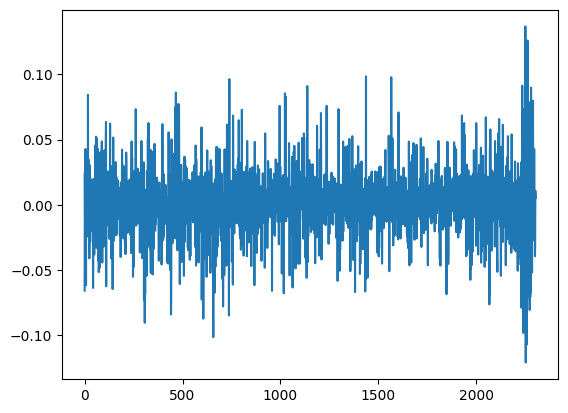

In [10]:
plt.plot(orig_data['Log_Return'])

In [11]:
# Filter the dataset for rows where Data_Source is 'Synthetic' and Extreme_Event_After is True
orig_data[(orig_data['Data_Source'] == 'Synthetic') & (orig_data['Extreme_Event_After'] == True)]

,Log_Return,Extreme_Event,Data_Source,Extreme_Event_After
7,-0.061630,False,Synthetic,True
17,0.084301,False,Synthetic,True
24,-0.041108,False,Synthetic,True
43,-0.063782,False,Synthetic,True
58,0.052276,False,Synthetic,True
...,...,...,...,...
2162,0.052626,False,Synthetic,True
2181,0.054050,False,Synthetic,True
2212,-0.050604,False,Synthetic,True
2272,0.078616,False,Synthetic,True


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Function to prepare data for LSTM model
def prepare_lstm_data(df, n_steps):
    X, y = [], []
    for i in range(len(df) - n_steps):
        X.append(df[i:i + n_steps])
        y.append(df[i + n_steps])
    return np.array(X), np.array(y)

# Number of past days to use for predicting the next value
n_steps = 10

# Selecting the 'Log_Return' column from prova_df for LSTM input
prova_log_returns = orig_data['Log_Return'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
prova_scaled = scaler.fit_transform(prova_log_returns)

# Prepare data for LSTM
X_prova, y_prova = prepare_lstm_data(prova_scaled, n_steps)

# Split the data into training and testing sets
X_train_prova, X_test_prova, y_train_prova, y_test_prova = train_test_split(X_prova, y_prova, test_size=0.01, random_state=42)

X_train_prova.shape, X_test_prova.shape, y_train_prova.shape, y_test_prova.shape


((2271, 10, 1), (23, 10, 1), (2271, 1), (23, 1))

In [13]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [14]:
X_train_prova.shape

(2271, 10, 1)

In [15]:
input_shape = (10,1)
#input_shape= (X_train_prova[1],X_train_prova[2])
model = create_lstm_model(input_shape)
history = model.fit(X_train_prova, y_train_prova, epochs=100, batch_size=32, validation_data=(X_test_prova, y_test_prova))


Epoch 1/100


/Users/filippoorlandi/Desktop/ARTICLE/Instructions_Article/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0578 - val_loss: 0.0092
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0108 - val_loss: 0.0090
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0112 - val_loss: 0.0090
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0101 - val_loss: 0.0091
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0103 - val_loss: 0.0090
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0100 - val_loss: 0.0094
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0111 - val_loss: 0.0091
Epoch 8/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0105 - val_loss: 0.0092
Epoch 9/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0101 - val_loss: 0.0088
Epoch 10/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0105 - val_loss: 0.0088
Epoch 11/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0105 - val_loss: 0.0089
Epoch 12/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0106 - val_lo

In [16]:
predicted_prova = model.predict(X_test_prova)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


In [17]:
from sklearn.metrics import mean_squared_error

# Inverse transform the predictions and actual values to their original scale
predicted_prova_inversed = scaler.inverse_transform(predicted_prova)
y_test_prova_inversed = scaler.inverse_transform(y_test_prova)

# Calculate MSE
mse_prova = mean_squared_error(y_test_prova_inversed, predicted_prova_inversed)
print("Mean Squared Error for Prova dataset:", mse_prova)


Mean Squared Error for Prova dataset: 0.0005802055002435949


In [19]:
from math import sqrt
rmse = sqrt (mse_prova)
rmse

0.024087455246322616

In [20]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test_prova_inversed, predicted_prova_inversed)

0.018825072463125224

In [21]:
# Generate predictions for the training set
predicted_train_prova = model.predict(X_train_prova)


71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [22]:
import matplotlib.pyplot as plt

# Inverse transform the predictions and actual values to their original scale
predicted_train_prova_inv = scaler.inverse_transform(predicted_train_prova)
y_train_prova_inv = scaler.inverse_transform(y_train_prova.reshape(-1, 1))


In [23]:
# Calculate mean and standard deviation of the actual values
mu = np.mean(y_train_prova_inv)
sigma = np.std(y_train_prova_inv)

# Identify indices of extreme values
extreme_indices = np.where((y_train_prova_inv < (mu - 2 * sigma)) | (y_train_prova_inv > (mu + 2 * sigma)))[0]

# Filter actual and predicted values for extreme values
actual_extreme_values = y_train_prova_inv[extreme_indices]
predicted_extreme_values = predicted_train_prova_inv[extreme_indices]

# Calculate RMSE for extreme values
rmse_extreme = np.sqrt(mean_squared_error(actual_extreme_values, predicted_extreme_values))

print(f'RMSE for Extreme Values: {rmse_extreme}')

RMSE for Extreme Values: 0.06894528955653684


In [24]:
mean_absolute_error(actual_extreme_values, predicted_extreme_values)

0.06700648531809553

test set


In [25]:
# Calculate mean and standard deviation of the actual values
mu = np.mean(y_test_prova_inversed)
sigma = np.std(y_test_prova_inversed)
# Identify indices of extreme values
extreme_indices = np.where((y_test_prova_inversed < (mu - 2 * sigma)) | (y_test_prova_inversed > (mu + 2 * sigma)))[0]

# Filter actual and predicted values for extreme values
actual_extreme_values = y_test_prova_inversed[extreme_indices]
predicted_extreme_values = predicted_prova_inversed[extreme_indices]

# Calculate RMSE for extreme values
rmse_extreme = np.sqrt(mean_squared_error(actual_extreme_values, predicted_extreme_values))

print(f'RMSE for Extreme Values: {rmse_extreme}')

RMSE for Extreme Values: 0.048186646611865565


In [26]:
mean_absolute_error(actual_extreme_values, predicted_extreme_values)

0.048186646611865565